In [41]:
# Install prerequesite libraries
#!pip install torch torchvision transformers datasets pandas seaborn

# 1. Dataset

In [42]:
# The chosen 13 + 1 labels
label_map = {
    18: "love",
    11: "disgust",
    17: "joy",
    25: "sadness",
    13: "excitement",
    14: "fear",
    2: "anger",
    15: "gratitude",
    12: "embarrassment",
    4: "approval",
    10: "disapproval",
    7: "curiosity",
    23: "relief",
    27: "neutral"
}

In [43]:
# Load dataset
from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions", "simplified")

# Access the train, validation, and test splits
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
train_dataset[0]

{'text': "My favourite food is anything I didn't have to cook myself.",
 'labels': [27],
 'id': 'eebbqej'}

### 1.1. Preprocess the dataset

In [45]:
from transformers import AutoTokenizer

# Experiment 3 - Tokenizer and Model. Setup 1.
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=28)

# Experiment 3 - Tokenizer and Model. Setup 2.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=28)


# Max sequence length in dataset = 30
def preprocess_dataset(example):
  # Tokenize the input text and return the encoded result
  encoding = tokenizer(example["text"], truncation=True, padding="max_length", max_length=30)
  return encoding

# Filter selected labels to remove labels that are not in the label_map
def filter_selected_labels(example):
  for i in example["labels"]:
    if int(i) in label_map.keys():
        return True
  return False

from torch.utils.data import DataLoader

# fill statistics data while mapping
label_frequency_statistics = {}
text_data = [example["text"] for example in dataset["train"]]
text_lengths = [len(text.split()) for text in text_data]

# Preprocess the dataset
train_dataset = train_dataset.map(preprocess_dataset, batched=True)
val_dataset = val_dataset.map(preprocess_dataset, batched=True)
test_dataset = test_dataset.map(preprocess_dataset, batched=True)

# Set dataset format to PyTorch tensors
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

train_dataset = train_dataset.filter(filter_selected_labels)
val_dataset = val_dataset.filter(filter_selected_labels)
test_dataset = test_dataset.filter(filter_selected_labels)

labels_debug = []
def map_selected_labels(example):
  label = [label for label in example["labels"] if int(label) in label_map.keys()][0]
  labels_debug.append(label)
  example["labels"] = [label]

  label = int(label)
  text = example["text"]
  if label not in label_frequency_statistics:
    label_frequency_statistics[label] = text
  else:
    label_frequency_statistics[label] += " " + text
  
  return example

train_dataset = train_dataset.map(map_selected_labels)
val_dataset = val_dataset.map(map_selected_labels)
test_dataset = test_dataset.map(map_selected_labels)

#print(labels_debug)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/3903 [00:00<?, ? examples/s]

In [46]:
# Verify we are only using existing classes
label_frequency_statistics.keys()

dict_keys([25, 13, 15, 27, 10, 18, 7, 14, 4, 17, 2, 11, 12, 23])

### Dataset analysis & charts

In [47]:
# Print first 100 labels in the dataset
print([int(label) for label in train_dataset["labels"][:100]])

[27, 27, 2, 14, 15, 27, 4, 27, 12, 15, 2, 27, 27, 12, 27, 27, 27, 2, 27, 25, 15, 27, 2, 27, 2, 17, 27, 25, 27, 15, 15, 27, 27, 7, 10, 27, 27, 27, 27, 27, 4, 27, 13, 10, 27, 27, 27, 15, 12, 27, 13, 27, 15, 27, 27, 27, 27, 27, 27, 13, 27, 13, 4, 25, 4, 27, 25, 15, 4, 27, 4, 27, 18, 4, 27, 7, 27, 7, 27, 10, 27, 27, 27, 7, 27, 15, 27, 27, 17, 27, 2, 2, 27, 27, 27, 4, 27, 2, 7, 2]


### 1.2 Prepare statistics data to be visualised

In [48]:
label_statistics = {label: 0 for label in label_map.values()}

# Gather statistics for piechart, barchart...
for example in train_dataset:
  for label_idx in example["labels"]:
    label = label_map[int(label_idx)]
    label_statistics[label] += 1

print("Label statistics:")
for label, count in label_statistics.items():
  print(f"{label}: {count}")

Label statistics:
love: 1830
disgust: 683
joy: 1227
sadness: 1179
excitement: 802
fear: 553
anger: 1567
gratitude: 2510
embarrassment: 276
approval: 2931
disapproval: 1929
curiosity: 2144
relief: 117
neutral: 13484


### 1.3 Visualise statistics

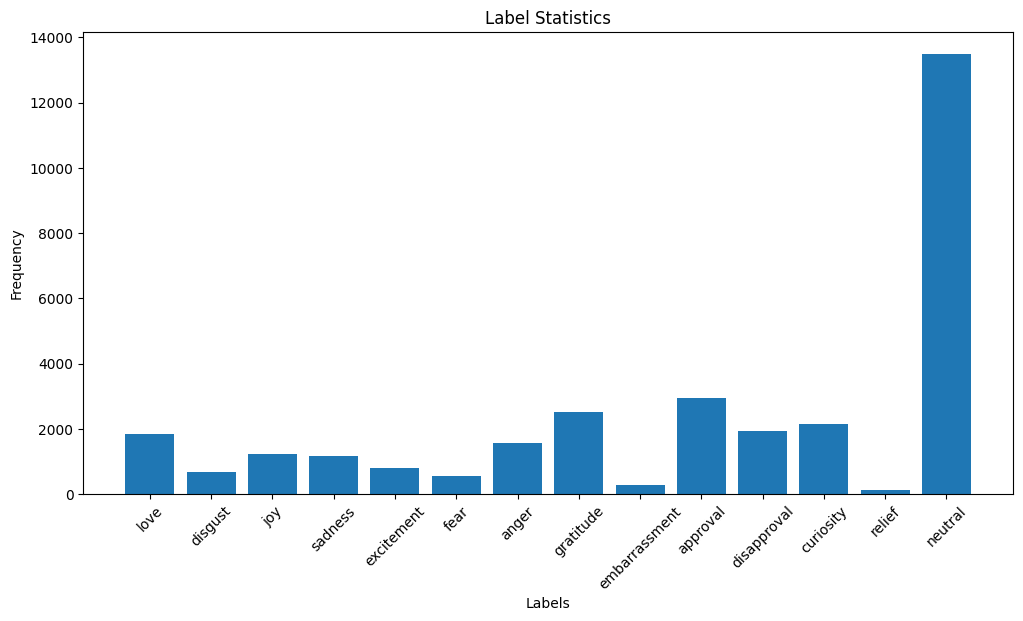

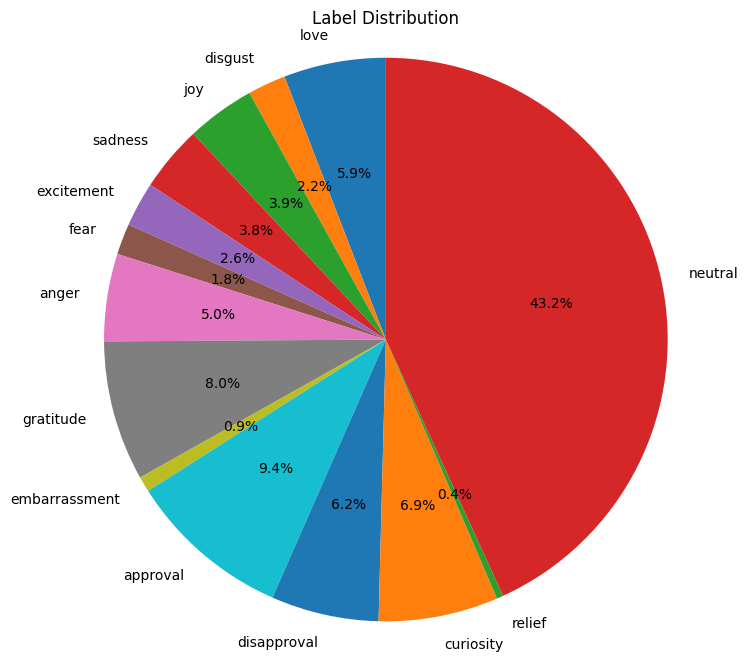

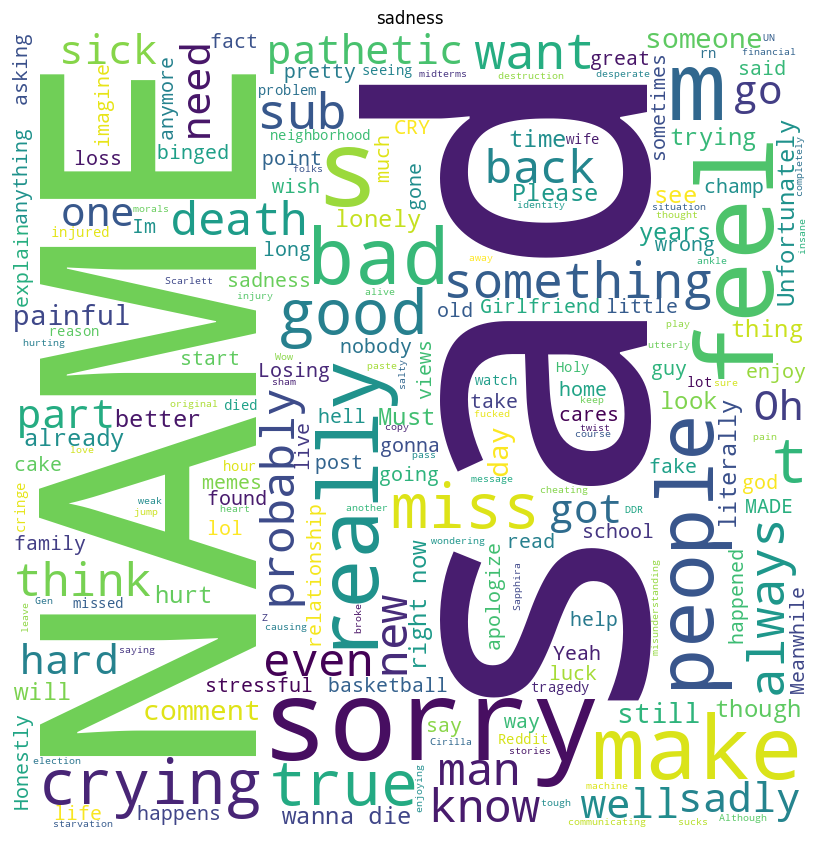

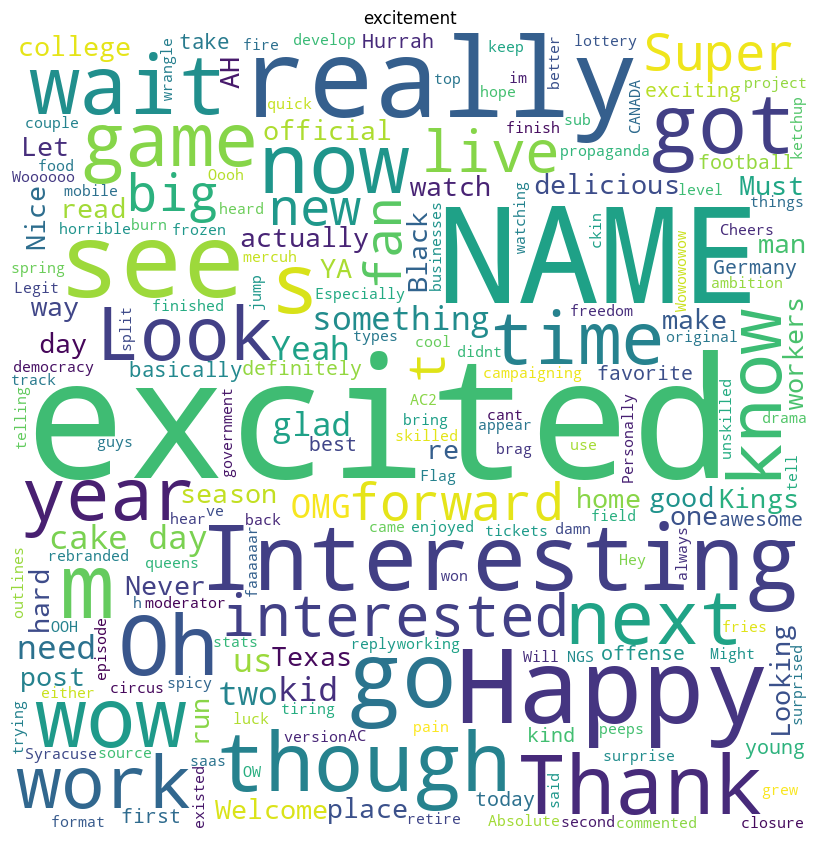

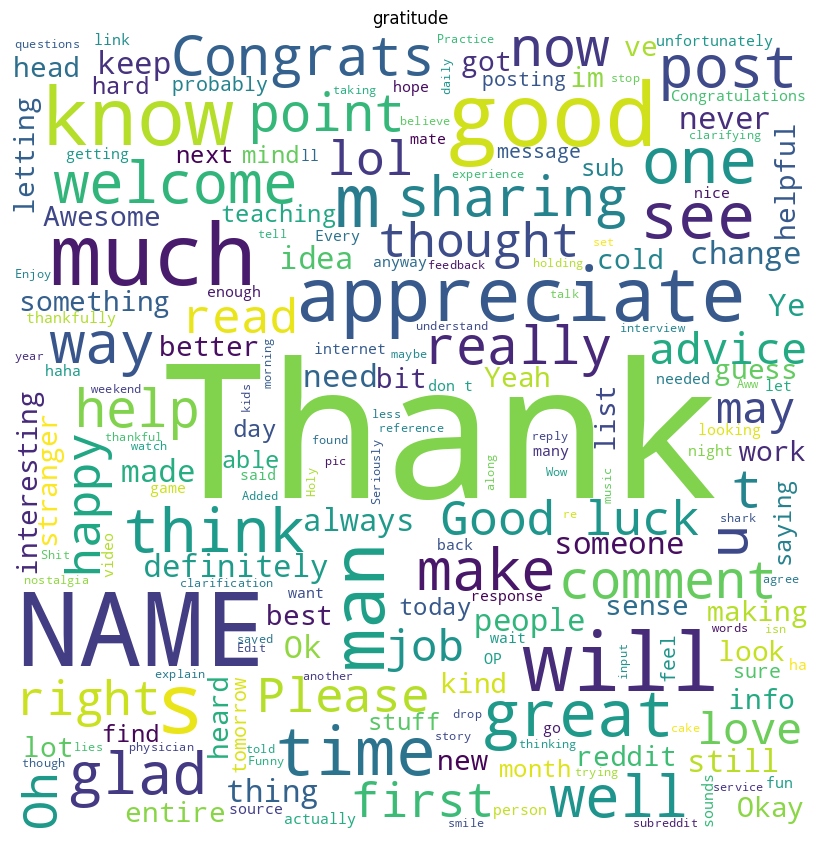

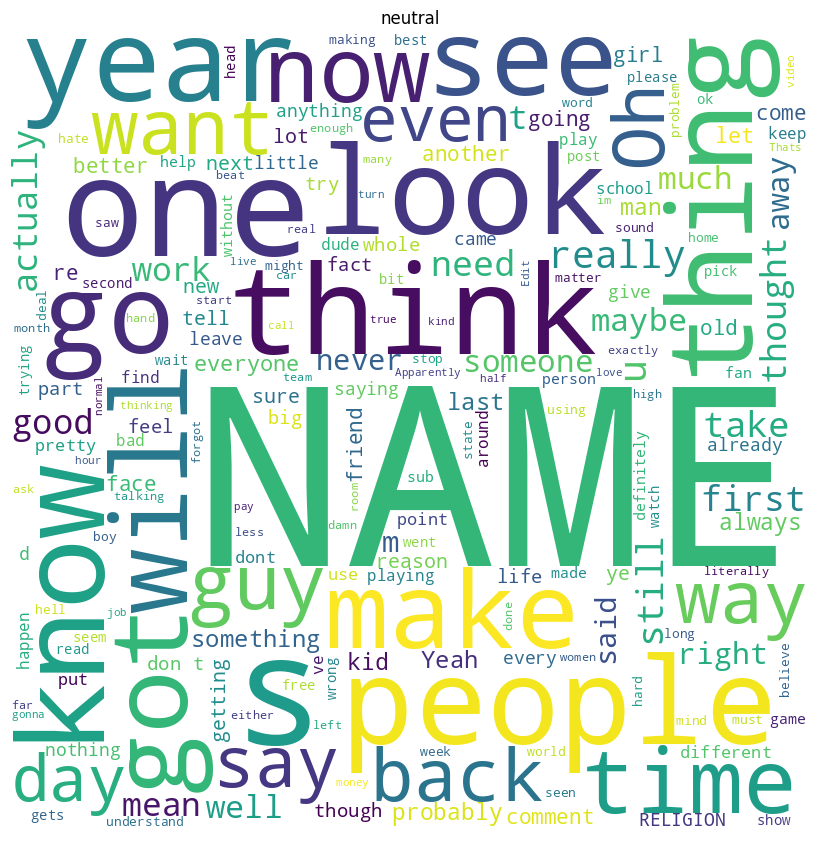

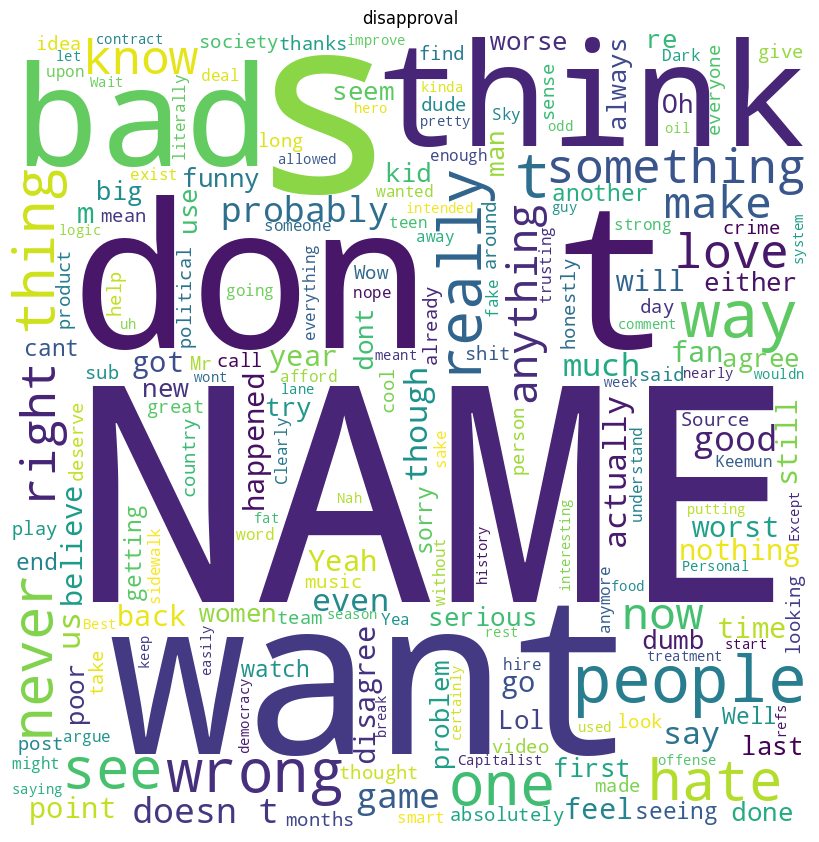

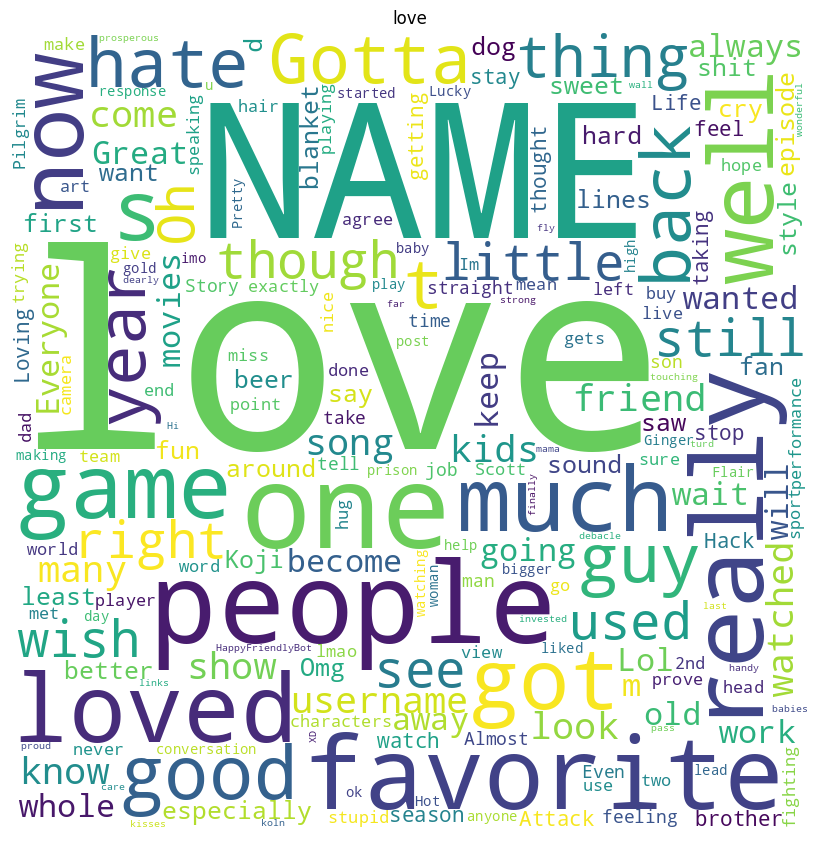

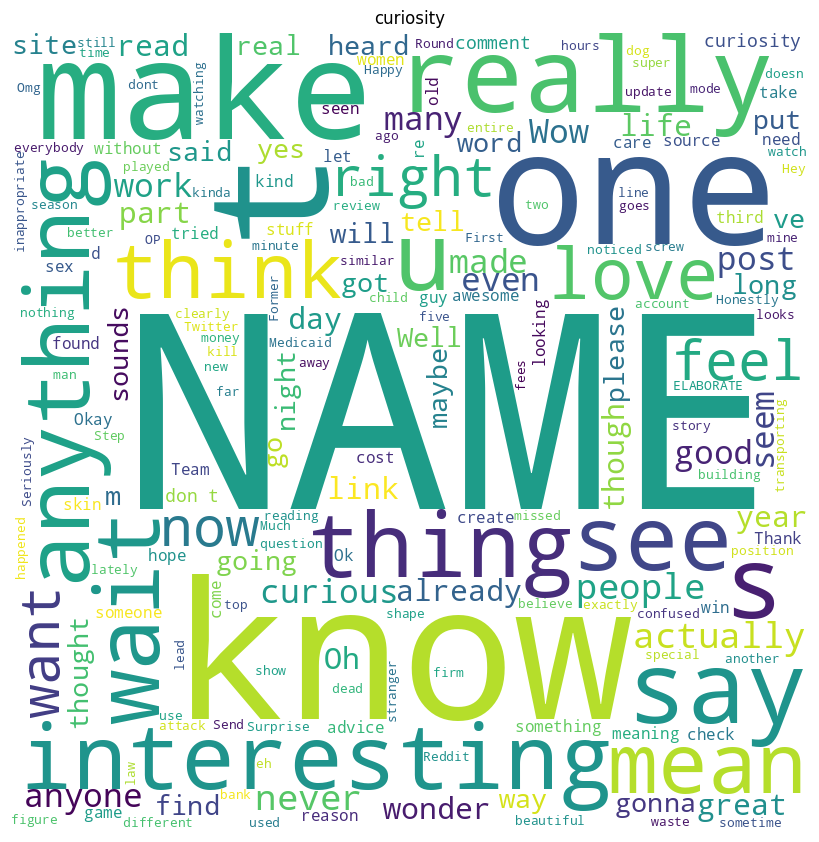

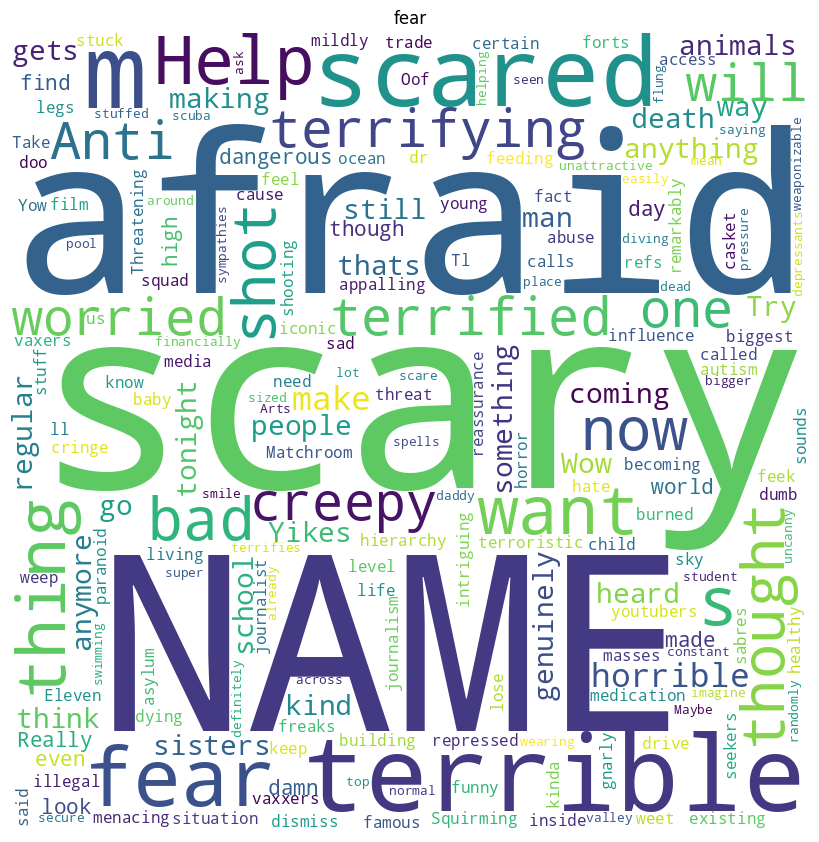

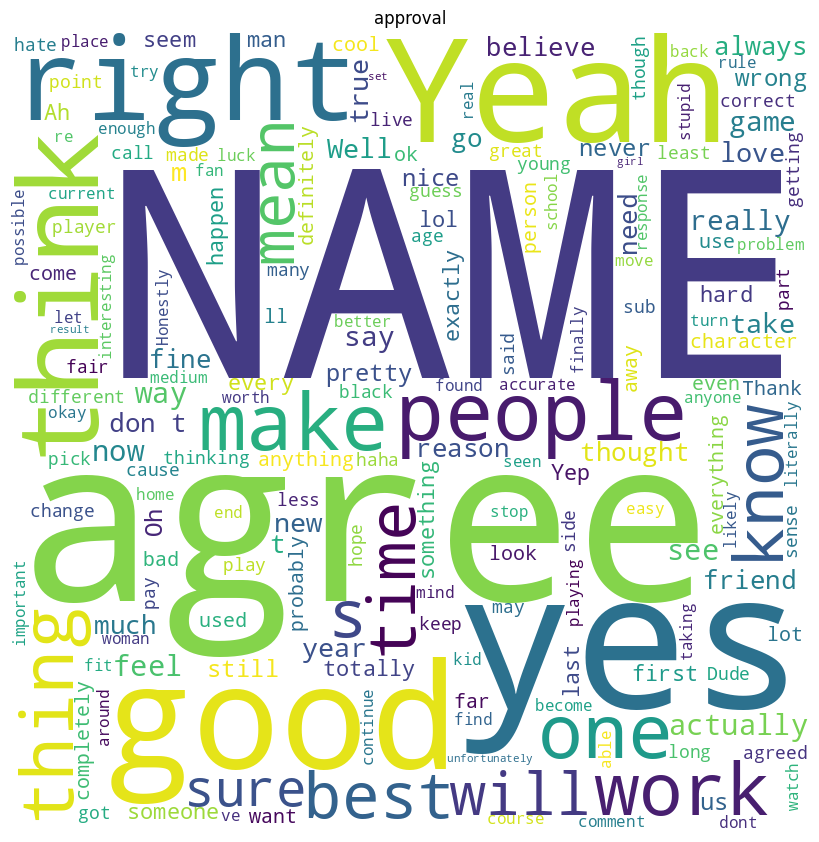

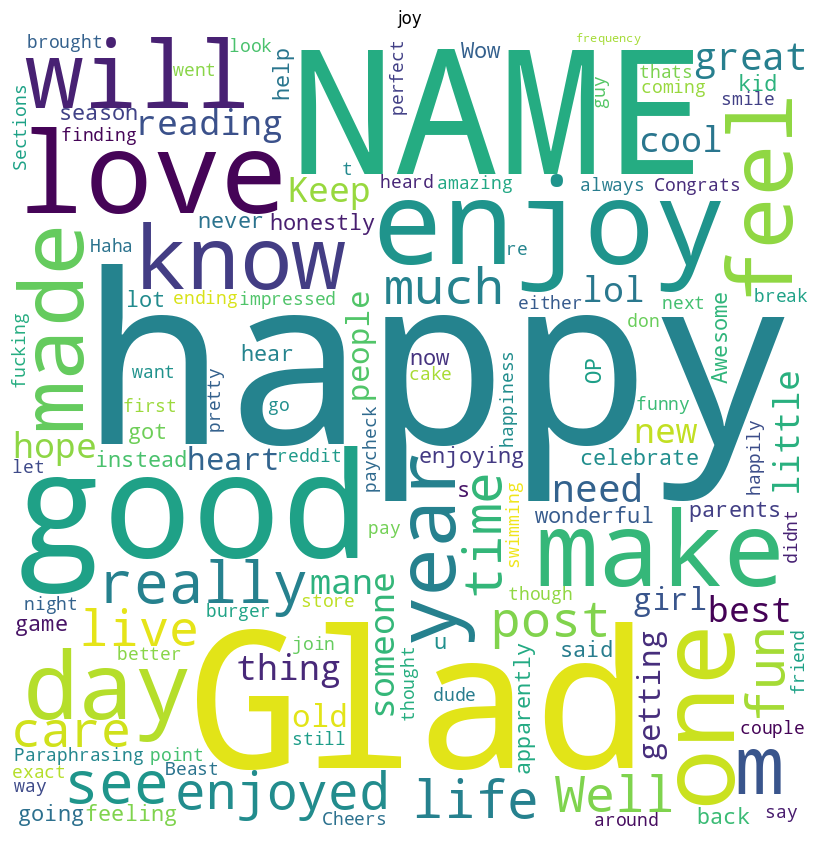

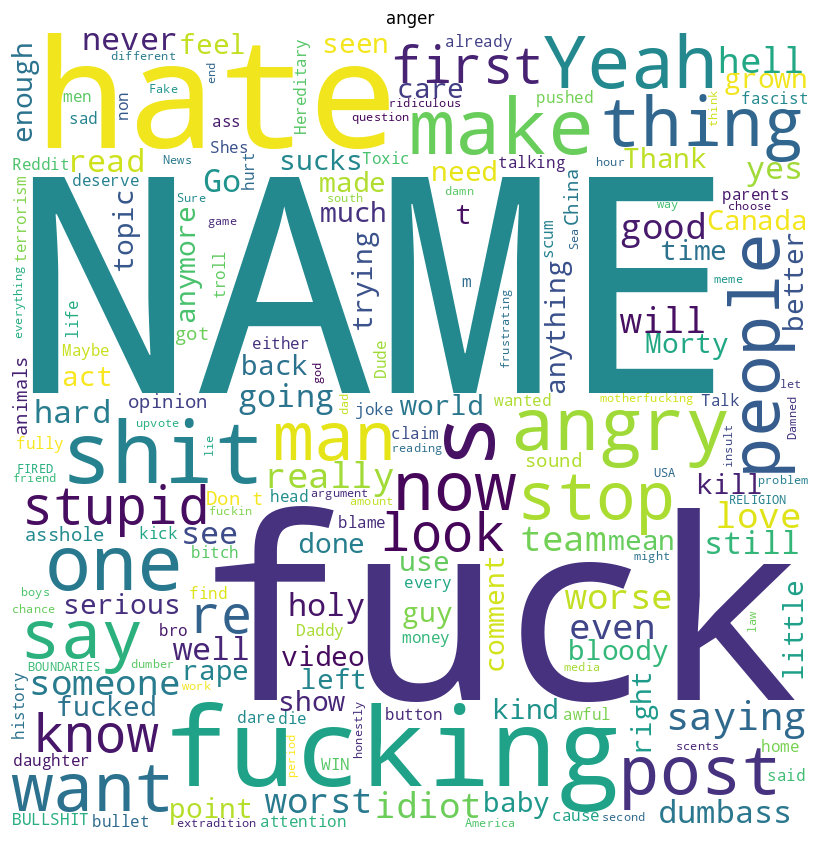

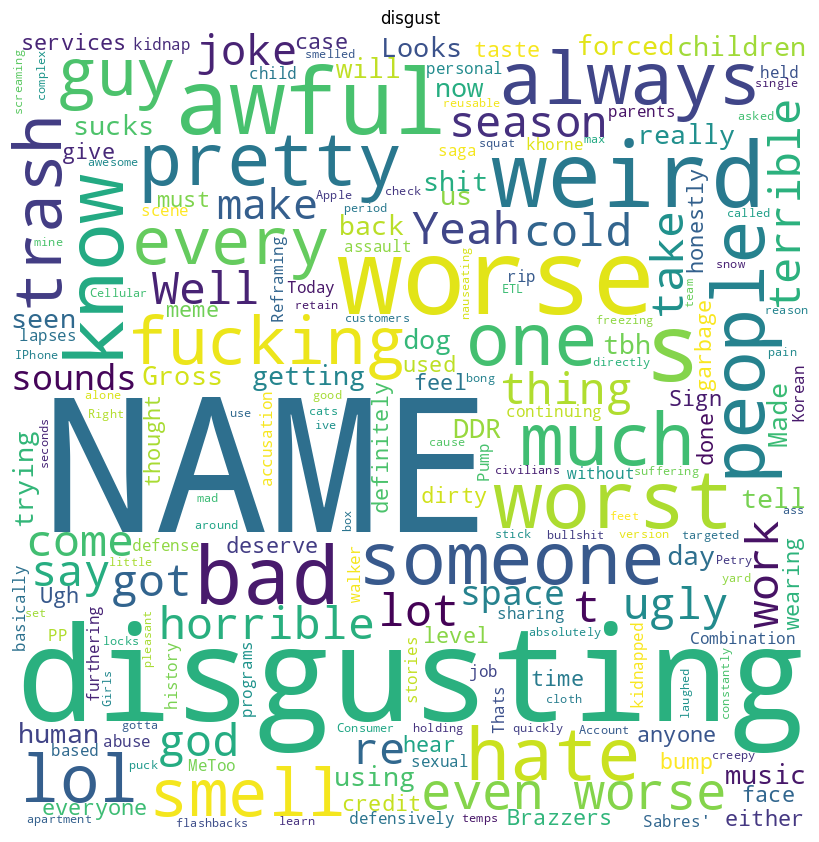

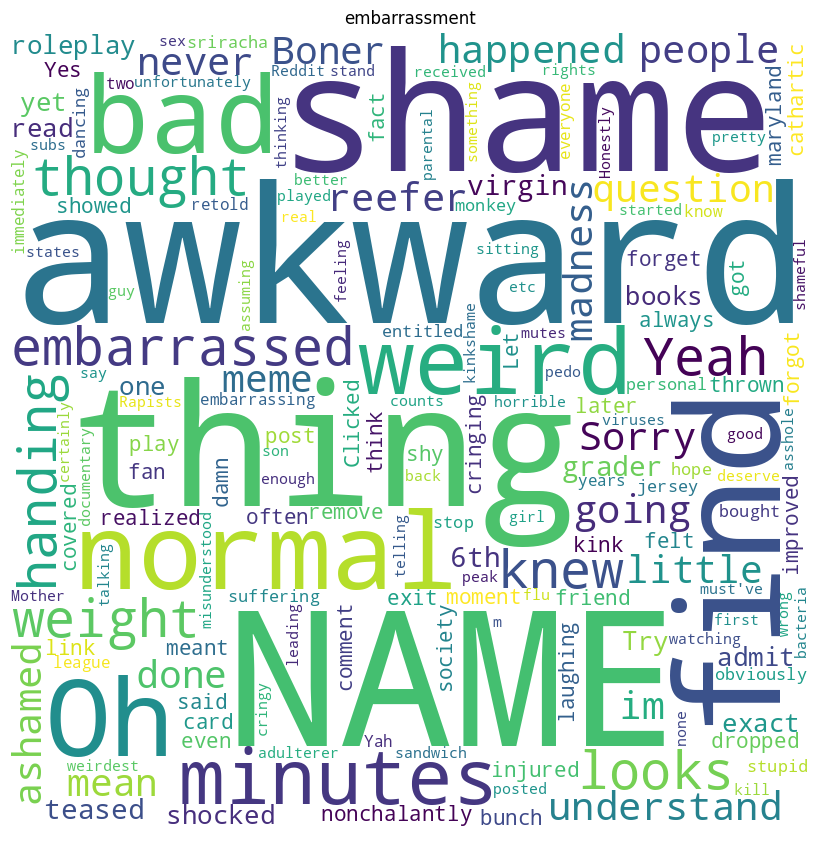

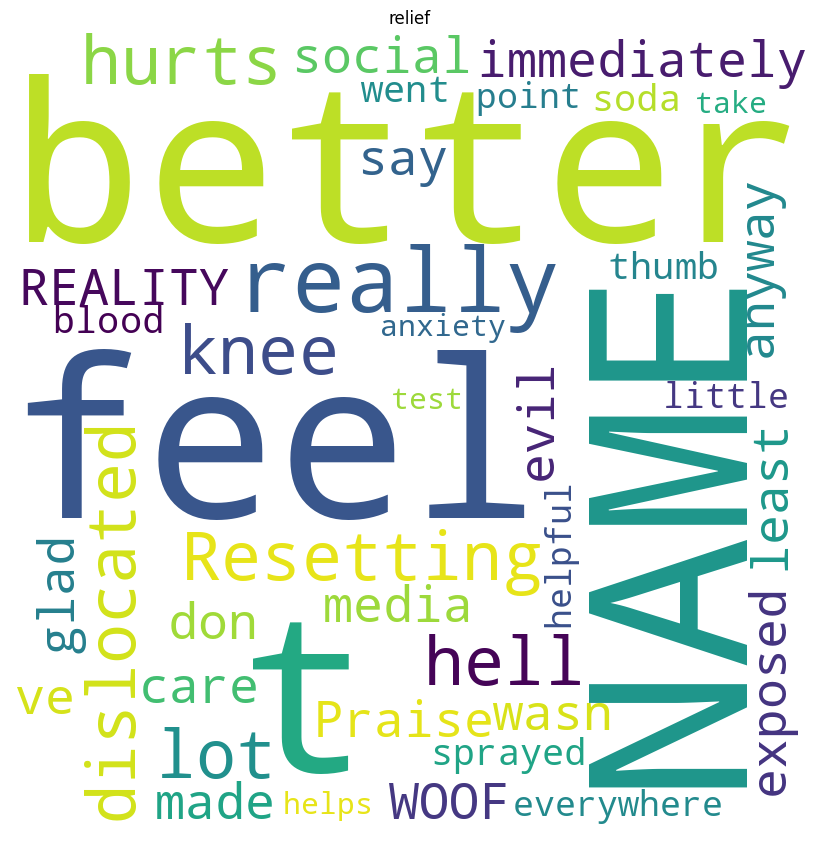

In [49]:
import matplotlib.pyplot as plt

# Bar chart for label statistics
plt.figure(figsize=(12, 6))
plt.bar(label_statistics.keys(), label_statistics.values())
plt.xlabel("Labels")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.title("Label Statistics")
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(label_statistics.values(), labels=label_statistics.keys(), autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Label Distribution")
plt.show()

from wordcloud import WordCloud

# Visualise label_frequency_statistics in a worldcloud
for label, text in label_frequency_statistics.items():
  wordcloud = WordCloud(width=800, height=800, background_color="white", min_font_size=10).generate(text)
  plt.figure(figsize=(8, 8), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.title(label_map[label])
  plt.show()


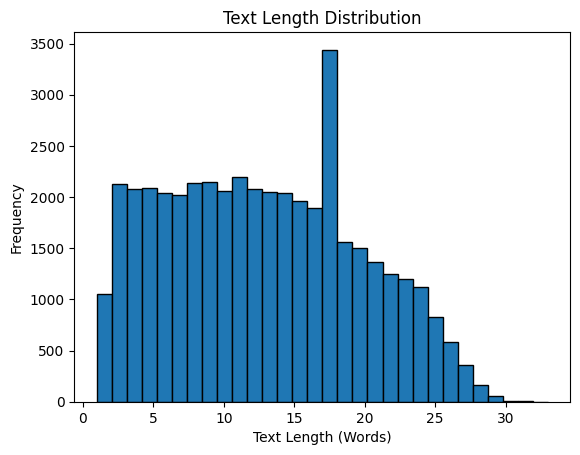

average text length: 12.840175074867542


In [50]:
# Text lengths histogram
plt.hist(text_lengths, bins=30, edgecolor="black")
plt.xlabel("Text Length (Words)")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.show()

avg_text_length = sum(text_lengths) / len(text_lengths)
print(f"average text length: {avg_text_length}")

---
## 2. Train

In [51]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [85]:
from transformers import Trainer, TrainingArguments
import torch.optim as optim
from datasets import load_metric
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

# Define custom optimizer function
def custom_optimizer(model, optimizer_name, training_args):
  if optimizer_name == "AdamW":
    return optim.AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)
  elif optimizer_name == "SGD":
    return optim.SGD(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)
  else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# function that computes the metrics
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  conf_matrix = confusion_matrix(labels, predictions)

  return {
    "accuracy": accuracy_metric.compute(predictions=predictions, references=labels),
    "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted"),
    "confusion_matrix": conf_matrix.tolist()
  }

# train with a specified optimizer for experimentation
def train_with_optimizer(optimizer_name):
    # Set training arguments
    training_args = TrainingArguments(
      output_dir="output",
      num_train_epochs=3,
      per_device_train_batch_size=32,
      per_device_eval_batch_size=32,
      evaluation_strategy="epoch",
      logging_dir="logs",
      learning_rate=1e-5,
      weight_decay=0.01,
    )

    optimizer = custom_optimizer(model, optimizer_name, training_args)

    # Define the Trainer
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      optimizers=(optimizer, None)
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the test dataset
    trainer.eval_dataset = test_dataset
    test_results = trainer.evaluate()
    print(f"Test results for {optimizer_name}:", test_results)
    return test_results

AdamW


Trainer is attempting to log a value of "{'accuracy': 0.6396833503575077}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6400855337264408}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[102, 4, 1, 12, 17, 0, 2, 3, 2, 0, 2, 0, 5, 45], [4, 164, 10, 19, 3, 0, 3, 1, 9, 8, 15, 0, 6, 153], [6, 4, 145, 6, 0, 0, 9, 1, 0, 2, 1, 0, 3, 61], [14, 11, 3, 126, 15, 0, 1, 0, 2, 0, 5, 0, 1, 109], [5, 5, 0, 7, 46, 1, 0, 2, 0, 0, 1, 0, 1, 17], [1, 2, 1, 4, 2, 15, 0, 0, 2, 0, 0, 0, 0, 5], [1, 7, 4, 0, 1, 0, 31, 0, 6, 11, 5, 0, 0, 21], [1, 4, 2, 3, 8, 1, 0, 49, 0, 0, 0, 0, 1, 13], [0, 12, 1, 2, 0, 0, 4, 1, 300, 9, 1, 0, 3, 8], [0, 17, 4, 2, 0, 0, 12, 0, 5, 86, 7, 0, 2, 10], [2, 9, 1, 2, 0, 0, 3, 1, 0, 7, 

Trainer is attempting to log a value of "{'accuracy': 0.6392518575454779}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6435816713826805}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[111, 4, 8, 18, 13, 0, 0, 0, 2, 0, 1, 0, 3, 38], [2, 175, 12, 14, 2, 0, 6, 2, 7, 5, 9, 1, 2, 114], [3, 4, 173, 3, 0, 1, 5, 2, 3, 2, 4, 0, 2, 70], [16, 10, 6, 114, 7, 2, 2, 2, 2, 1, 5, 0, 9, 76], [14, 3, 2, 7, 56, 1, 0, 6, 0, 0, 0, 1, 0, 17], [2, 3, 1, 3, 3, 11, 1, 0, 0, 0, 0, 0, 2, 7], [0, 6, 4, 2, 0, 0, 47, 2, 5, 13, 0, 0, 0, 20], [2, 3, 1, 2, 4, 0, 1, 55, 0, 0, 0, 0, 0, 9], [0, 11, 7, 1, 0, 0, 9, 0, 292, 5, 0, 2, 2, 6], [1, 12, 2, 1, 0, 0, 11, 1, 5, 83, 7, 0, 0, 14], [2, 17, 2, 6, 1, 0, 2, 0, 1, 6, 15

Test results for AdamW: {'eval_loss': 1.8158667087554932, 'eval_accuracy': {'accuracy': 0.6392518575454779}, 'eval_f1': {'f1': 0.6435816713826805}, 'eval_confusion_matrix': [[111, 4, 8, 18, 13, 0, 0, 0, 2, 0, 1, 0, 3, 38], [2, 175, 12, 14, 2, 0, 6, 2, 7, 5, 9, 1, 2, 114], [3, 4, 173, 3, 0, 1, 5, 2, 3, 2, 4, 0, 2, 70], [16, 10, 6, 114, 7, 2, 2, 2, 2, 1, 5, 0, 9, 76], [14, 3, 2, 7, 56, 1, 0, 6, 0, 0, 0, 1, 0, 17], [2, 3, 1, 3, 3, 11, 1, 0, 0, 0, 0, 0, 2, 7], [0, 6, 4, 2, 0, 0, 47, 2, 5, 13, 0, 0, 0, 20], [2, 3, 1, 2, 4, 0, 1, 55, 0, 0, 0, 0, 0, 9], [0, 11, 7, 1, 0, 0, 9, 0, 292, 5, 0, 2, 2, 6], [1, 12, 2, 1, 0, 0, 11, 1, 5, 83, 7, 0, 0, 14], [2, 17, 2, 6, 1, 0, 2, 0, 1, 6, 157, 0, 2, 7], [0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0], [4, 3, 6, 6, 0, 0, 1, 2, 3, 0, 0, 0, 90, 26], [45, 178, 101, 100, 17, 8, 22, 12, 11, 17, 18, 1, 33, 1128]], 'eval_runtime': 7.7544, 'eval_samples_per_second': 503.328, 'eval_steps_per_second': 15.733, 'epoch': 3.0}
SGD


Trainer is attempting to log a value of "{'accuracy': 0.6310010214504597}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6329190801391665}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[110, 5, 1, 11, 11, 1, 2, 2, 2, 0, 4, 0, 5, 41], [7, 182, 10, 12, 1, 0, 5, 3, 9, 9, 15, 2, 6, 134], [6, 3, 154, 6, 0, 0, 9, 2, 1, 2, 0, 0, 3, 52], [22, 16, 5, 122, 10, 2, 1, 0, 2, 0, 5, 0, 3, 99], [6, 4, 0, 7, 42, 0, 0, 4, 0, 0, 4, 0, 2, 16], [1, 2, 1, 4, 1, 14, 0, 0, 2, 0, 0, 0, 2, 5], [1, 6, 3, 0, 1, 0, 35, 0, 6, 10, 6, 0, 0, 19], [1, 5, 3, 3, 8, 1, 0, 48, 0, 0, 0, 0, 1, 12], [0, 11, 1, 2, 0, 0, 4, 1, 302, 9, 2, 0, 3, 6], [0, 16, 3, 1, 0, 0, 11, 0, 10, 84, 7, 0, 2, 11], [2, 10, 0, 2, 0, 0, 4, 1, 0, 5,

Trainer is attempting to log a value of "{'accuracy': 0.641301562900333}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6454516727148953}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[111, 4, 8, 18, 13, 0, 0, 0, 2, 0, 1, 0, 3, 38], [2, 175, 12, 14, 2, 0, 6, 2, 7, 5, 9, 1, 2, 114], [3, 4, 173, 3, 0, 1, 5, 2, 3, 2, 4, 0, 2, 70], [16, 10, 6, 114, 7, 2, 2, 2, 2, 1, 5, 0, 9, 76], [14, 3, 2, 7, 56, 1, 0, 6, 0, 0, 0, 1, 0, 17], [2, 3, 1, 3, 3, 11, 1, 0, 0, 0, 0, 0, 2, 7], [0, 6, 4, 2, 0, 0, 47, 2, 5, 13, 0, 0, 0, 20], [2, 3, 1, 2, 4, 0, 1, 55, 0, 0, 0, 0, 0, 9], [0, 11, 7, 1, 0, 0, 9, 0, 292, 5, 0, 2, 2, 6], [1, 12, 2, 1, 0, 0, 10, 1, 5, 84, 7, 0, 0, 14], [2, 17, 2, 6, 1, 0, 2, 0, 1, 6, 157

Test results for SGD: {'eval_loss': 1.8135710954666138, 'eval_accuracy': {'accuracy': 0.641301562900333}, 'eval_f1': {'f1': 0.6454516727148953}, 'eval_confusion_matrix': [[111, 4, 8, 18, 13, 0, 0, 0, 2, 0, 1, 0, 3, 38], [2, 175, 12, 14, 2, 0, 6, 2, 7, 5, 9, 1, 2, 114], [3, 4, 173, 3, 0, 1, 5, 2, 3, 2, 4, 0, 2, 70], [16, 10, 6, 114, 7, 2, 2, 2, 2, 1, 5, 0, 9, 76], [14, 3, 2, 7, 56, 1, 0, 6, 0, 0, 0, 1, 0, 17], [2, 3, 1, 3, 3, 11, 1, 0, 0, 0, 0, 0, 2, 7], [0, 6, 4, 2, 0, 0, 47, 2, 5, 13, 0, 0, 0, 20], [2, 3, 1, 2, 4, 0, 1, 55, 0, 0, 0, 0, 0, 9], [0, 11, 7, 1, 0, 0, 9, 0, 292, 5, 0, 2, 2, 6], [1, 12, 2, 1, 0, 0, 10, 1, 5, 84, 7, 0, 0, 14], [2, 17, 2, 6, 1, 0, 2, 0, 1, 6, 157, 0, 2, 7], [0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0], [4, 3, 6, 6, 0, 0, 1, 2, 3, 0, 0, 0, 90, 26], [44, 175, 99, 99, 17, 8, 22, 12, 11, 17, 18, 1, 33, 1135]], 'eval_runtime': 7.463, 'eval_samples_per_second': 522.98, 'eval_steps_per_second': 16.347, 'epoch': 3.0}
Validation results:
  Loss: 1.8159
  Accuracy: 0.6393

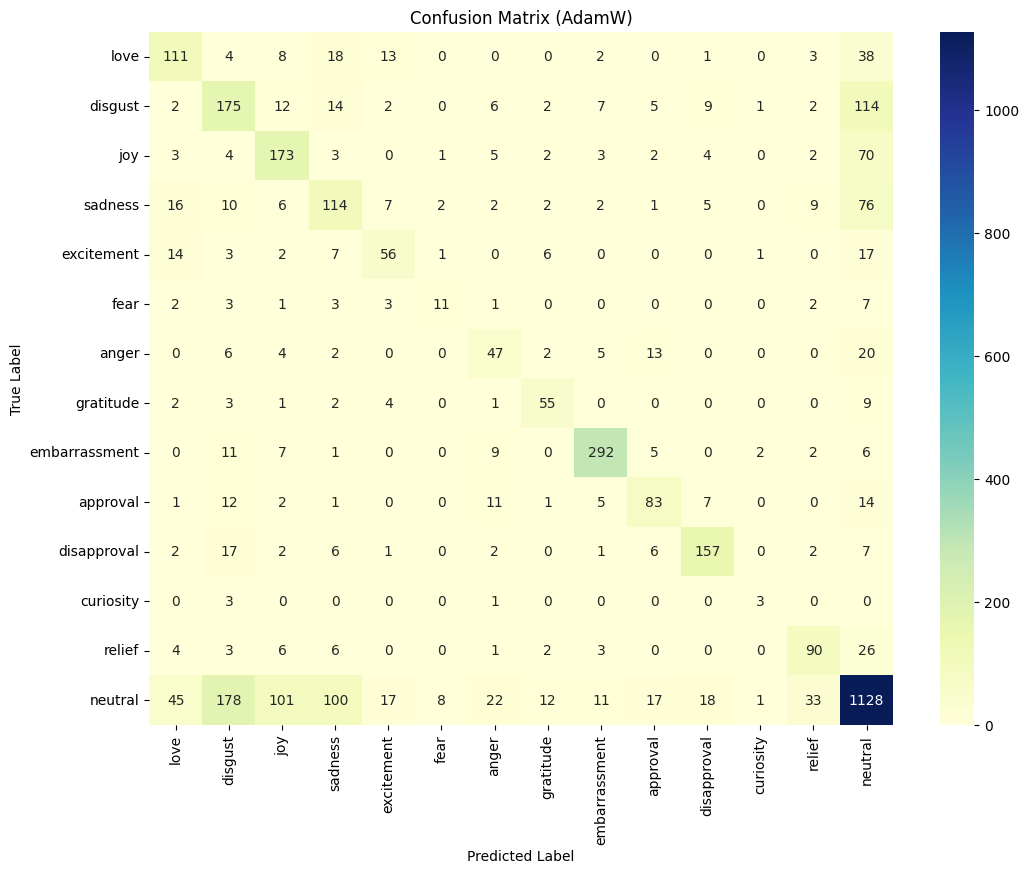

Validation results:
  Loss: 1.8136
  Accuracy: 0.6413
  F1 score: 0.6455
  Runtime: 7.4630
  Samples per second: 522.9800
  Steps per second: 16.3470

Test results:
  Loss: 1.8136
  Accuracy: 0.6413
  F1 score: 0.6455
  Runtime: 7.4630
  Samples per second: 522.9800
  Steps per second: 16.3470



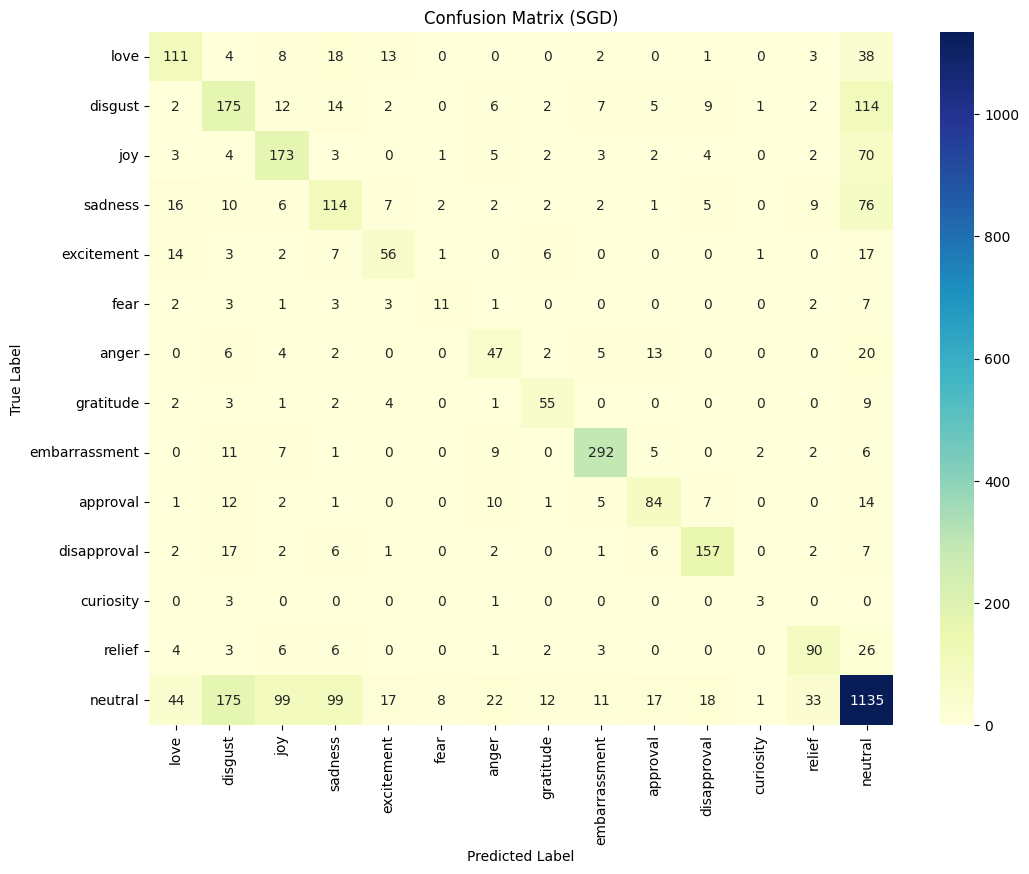

In [86]:
# perform training with listed optimizers
optimizers = ["AdamW", "SGD"]
results = {}

for optimizer_name in optimizers:
  print(optimizer_name)
  results[optimizer_name] = train_with_optimizer(optimizer_name)

# Pretty print the results
def print_results(results, dataset_name):
    print(f"{dataset_name} results:")
    print(f"  Loss: {results['eval_loss']:.4f}")
    print(f"  Accuracy: {results['eval_accuracy']['accuracy']:.4f}")
    print(f"  F1 score: {results['eval_f1']['f1']:.4f}")
    print(f"  Runtime: {results['eval_runtime']:.4f}")
    print(f"  Samples per second: {results['eval_samples_per_second']:.4f}")
    print(f"  Steps per second: {results['eval_steps_per_second']:.4f}")
    print()

def generate_confusion_matrix(results, title):
  conf_matrix = results["eval_confusion_matrix"]

  # Create a DataFrame for better visualization
  conf_matrix_df = pd.DataFrame(conf_matrix, index=label_map.values(), columns=label_map.values())

  # Visualize the confusion matrix using seaborn
  plt.figure(figsize=(12, 9))
  sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="YlGnBu")
  plt.title(f"Confusion Matrix ({title})")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

for optim in optimizers:
  print_results(results[optim], "Validation")
  print_results(results[optim], "Test")
  generate_confusion_matrix(results[optim], optim)

In [88]:
for optim in optimizers:
  print_results(results[optim], f"Validation: [{optim}]")
  print_results(results[optim], f"Test: [{optim}]")
  #generate_confusion_matrix(results[optim], optim)

Validation: [AdamW] results:
  Loss: 1.8159
  Accuracy: 0.6393
  F1 score: 0.6436
  Runtime: 7.7544
  Samples per second: 503.3280
  Steps per second: 15.7330

Test: [AdamW] results:
  Loss: 1.8159
  Accuracy: 0.6393
  F1 score: 0.6436
  Runtime: 7.7544
  Samples per second: 503.3280
  Steps per second: 15.7330

Validation: [SGD] results:
  Loss: 1.8136
  Accuracy: 0.6413
  F1 score: 0.6455
  Runtime: 7.4630
  Samples per second: 522.9800
  Steps per second: 16.3470

Test: [SGD] results:
  Loss: 1.8136
  Accuracy: 0.6413
  F1 score: 0.6455
  Runtime: 7.4630
  Samples per second: 522.9800
  Steps per second: 16.3470



### Visualise confusion matrix

In [56]:
output_dir = "."
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json',
 './tokenizer.json')